# **Import Modules**

In [1]:
import sys

import os

import random as pyrand

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

sys.path.insert(0, '../input/deeplearning-utils')

In [2]:
from utils.ops import plot

from utils.tf.ops import io, eval as tf_eval

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns

from sklearn.model_selection import KFold

from tqdm import tqdm

In [4]:
from IPython.display import Image, display

In [5]:
from kaggle_secrets import UserSecretsClient
from kaggle_datasets import KaggleDatasets

In [6]:
import tensorflow as tf

from tensorflow.keras import backend, optimizers, regularizers

from tensorflow.keras.layers import *

from tensorflow.keras.models import Sequential, Model

# from tensorflow.keras.applications import *

from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_addons as tfa

# **Config**

In [7]:
def set_seed(tf_seed=0, np_seed=0, py_rand=0, py_hash=0):

    os.environ['PYTHONHASHSEED'] = str(py_hash)
    pyrand.seed(py_rand)

    tf.random.set_seed(tf_seed)
    np.random.seed(np_seed)

In [8]:
PATH = {'224': 'cisc22placesandscene224x224'}

In [9]:
class Config:
    
    SEED = 256
    
    IMAGE_SIZE = (224, 224)

    TRAIN_BATCH_SIZE = 32
    VAL_BATCH_SIZE = 32
        
    SPLIT = 10
        
    EPOCHS = 100
    
    TRAINING = False

In [10]:
set_seed(Config.SEED)

In [11]:
try:
    
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    
    print('Running on TPU ', tpu.master())
    
except ValueError:
  
    tpu = None

if tpu is not None:
    
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy(tpu)

else:
    
    strategy = tf.distribute.get_strategy()


print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [12]:
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()

user_secrets.set_tensorflow_credential(user_credential)

GCS_DS_PATH = KaggleDatasets().get_gcs_path(PATH['224'])

In [13]:
augmentations = []

augmentations.append(preprocessing.RandomFlip(mode='horizontal'))
augmentations.append(preprocessing.RandomContrast(factor=0.8))
augmentations.append(preprocessing.RandomRotation(factor=0.1, dtype=tf.float32))

augmentations = Sequential(augmentations)

# **Load Data**

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

In [15]:
train_rec = tf.io.gfile.glob(GCS_DS_PATH + '/train/train/*')

train_rec = np.array(train_rec)

print(len(train_rec))

50


In [16]:
def processing(x, y):
        
    x = tf.cast(x, dtype=tf.float32)
    x /= 255.0
    
    y = tf.one_hot(y, depth=6)
    
    return x, y

In [17]:
def split_generator(train_idx, val_idx):
    
    dtype = {'image': 'bytes', 'label': 'int64'}
    
    reader = io.TfRecordReader(features_dtype=dtype,  image_key='image', 
                               tfrecord_shape=[*Config.IMAGE_SIZE, 3],  
                               shape=None, channels=3,  func=None)
    
    train_data = tf.data.TFRecordDataset(train_rec[train_idx], num_parallel_reads=AUTOTUNE)
    train_data = train_data.with_options(ignore_order)

    train_data = train_data.map(reader.read_tfrecord, num_parallel_calls=AUTOTUNE)
    train_data = train_data.batch(Config.TRAIN_BATCH_SIZE)
    train_data = train_data.prefetch(AUTOTUNE)
    train_data = train_data.map(processing)
    
    val_data = tf.data.TFRecordDataset(train_rec[val_idx], num_parallel_reads=AUTOTUNE)
    val_data = val_data.with_options(ignore_order)

    val_data = val_data.map(reader.read_tfrecord, num_parallel_calls=AUTOTUNE)
    val_data = val_data.batch(Config.VAL_BATCH_SIZE)
    val_data = val_data.prefetch(AUTOTUNE)
    val_data = val_data.map(processing)
    
    return train_data, val_data

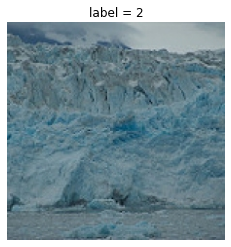

In [18]:
sample_x, sample_y = split_generator(0, 1)[0].unbatch().as_numpy_iterator().next()

plt.imshow(sample_x)
plt.title(f'label = {int(sample_y.argmax())}')
plt.axis('off')
plt.show()

In [103]:
src_dir = '../input/ci-sc22-places-and-scene-recognition/'

test_path = tf.io.gfile.glob(src_dir + '/test_images/test_images/*')

print(len(test_path))

3407


In [20]:
def read_test_example(path):
    
    image_name = os.path.split(path)[1]
    image_name = np.expand_dims(image_name, axis=0)
    
    image = io.read_image(path)
    image = tf.expand_dims(image, axis=0)
    image = tf.image.resize(image, Config.IMAGE_SIZE)
    image = tf.cast(image, dtype=tf.float32)

    image /= 255.0
    
    return image, image_name

In [21]:
def test_generator():
    
    for i in range(len(test_path)):
        
        yield read_test_example(test_path[i])

# **Build Model**

In [22]:
input_shape = (*Config.IMAGE_SIZE, 3)

In [23]:
with strategy.scope():
    
    vgg16 =  tf.keras.models.load_model('../input/cisc22buildvgg16/vgg16_places365_no_top.h5', compile=False)
        
    outputs = []
    
    outputs.append(vgg16.get_layer('block2_pool').output)
    outputs.append(vgg16.get_layer('block3_pool').output)
    outputs.append(vgg16.get_layer('block4_pool').output)
    outputs.append(vgg16.get_layer('block5_pool').output)
    
    backbone = Model(vgg16.inputs, outputs)

In [24]:
def build_model():
    
    backbone.trainable = False
    
    # ===================================================================================
    
    inputs = Input(shape=input_shape)
    
    inception = backbone(inputs)
    
    features = []
    
    activation = ['linear', 'relu', 'relu', 'relu']
    
    dropout_rate = [None, None, None, None]
    
    for i in range(len(inception)):
                    
        fi = Conv2D(1024, (1, 1), activation=activation[i], name=f'conv_{i}0')(inception[i])
        fi = Conv2D(1024, (1, 1), activation=activation[i], name=f'conv_{i}1')(fi)
        
        if dropout_rate[i] is not None:
            
            fi = Dropout(dropout_rate[i])(fi)
            
        fi = GlobalAveragePooling2D()(fi)
        
        features.append(fi)
    
    features = Concatenate(axis=-1, name='features')(features)
    
    # ===================================================================================

    y_logits = Dense(6, name='y_logits')(features)
    y_proba = Activation('softmax', name='y_proba')(y_logits)
    
    # ===================================================================================

    model = Model(inputs, y_proba)
    
    # ===================================================================================
    
    optimizer = optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)
    
    loss = tf.losses.CategoricalCrossentropy(label_smoothing=0.25, name='categorical_crossentropy')
    metrics = tf.metrics.CategoricalAccuracy(name='accuracy_score')
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    # ===================================================================================

    return model

# **Load Old Models**

In [53]:
vgg16_v1 = 'https://www.kaggleusercontent.com/kf/83044993/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..64XNqB2gzSeamtASYbm8Jg.Vyx2UrYYo5aw1BvvOZLi_wgPoQ4126II5bKb3ZDZSKAlPGWNrUUazMesiOZvMotVuZpPS8bELpHJDqNKR5QqHsaDm2HOCTxGz6wYbqP6EXq_S91rGpCPNf_nXb9CLSFXRNS8zhR9X4MwBzf9myBfPGh_aIqaCwBHzGI4C3_eMSEPSFuO9iGxKG0DtoD2mP2Xn7Gk97ALaj1meNU3QEulyYznpXIPAg79qkvYPXvxBBjVCCmcxFBCEfw3I6Vx4BIAmaZxYOTvcF5w1IdlSEbDLSC2bKhnLXe0uqgfL_vcR40dEKrplbCAvGv_uez7_5ea2m883m8VHrvA3Wlo1Pa1pRLpH72hIy0AmYqFwcRQDQ_NyEjVbnSNPeUrifapN0TcNMFipDEQrKJHyfsNW1fXf4veZU2HwV6CSwiNB2PpYycGTIgehxZUYoA40pd72Vwjwy5tkUu1WbvXKWrLoboi-JjiLGe1fEzNTzCKy4DizklBew785gQryamcdrrHpQK8aILHBH6rambN2w-2nCLb6XXlq_JfEhZ_4KulaJyMl0i7agstIb_0vbmBUoguaQAJfVpOZZG5pRRNSwFNKsuJtHwrrJyznrOsgIVJmQWvGbU-8Ez5vV4X-t0WTW2ur2NdrphakGJOPiUGpcx0d417c6TOsifO_v9W3rKxPhOtqwlGlbtrVn3F4t3CAqQs1zOH.Kf3TdyGm1sH3ypQUXFf_pg/weights-0.h5'

In [54]:
!wget $vgg16_v1

!mv ./weights-0.h5 ./vgg16_v1.h5

--2021-12-26 17:35:02--  https://www.kaggleusercontent.com/kf/83044993/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..64XNqB2gzSeamtASYbm8Jg.Vyx2UrYYo5aw1BvvOZLi_wgPoQ4126II5bKb3ZDZSKAlPGWNrUUazMesiOZvMotVuZpPS8bELpHJDqNKR5QqHsaDm2HOCTxGz6wYbqP6EXq_S91rGpCPNf_nXb9CLSFXRNS8zhR9X4MwBzf9myBfPGh_aIqaCwBHzGI4C3_eMSEPSFuO9iGxKG0DtoD2mP2Xn7Gk97ALaj1meNU3QEulyYznpXIPAg79qkvYPXvxBBjVCCmcxFBCEfw3I6Vx4BIAmaZxYOTvcF5w1IdlSEbDLSC2bKhnLXe0uqgfL_vcR40dEKrplbCAvGv_uez7_5ea2m883m8VHrvA3Wlo1Pa1pRLpH72hIy0AmYqFwcRQDQ_NyEjVbnSNPeUrifapN0TcNMFipDEQrKJHyfsNW1fXf4veZU2HwV6CSwiNB2PpYycGTIgehxZUYoA40pd72Vwjwy5tkUu1WbvXKWrLoboi-JjiLGe1fEzNTzCKy4DizklBew785gQryamcdrrHpQK8aILHBH6rambN2w-2nCLb6XXlq_JfEhZ_4KulaJyMl0i7agstIb_0vbmBUoguaQAJfVpOZZG5pRRNSwFNKsuJtHwrrJyznrOsgIVJmQWvGbU-8Ez5vV4X-t0WTW2ur2NdrphakGJOPiUGpcx0d417c6TOsifO_v9W3rKxPhOtqwlGlbtrVn3F4t3CAqQs1zOH.Kf3TdyGm1sH3ypQUXFf_pg/weights-0.h5
Resolving www.kaggleusercontent.com (www.kaggleusercontent.com)... 35.190.26.106
Connecting to www.kaggleusercontent

In [58]:
with strategy.scope():
    
    vgg16 =  tf.keras.models.load_model('../input/cisc22buildvgg16/vgg16_imagenet_top.h5', compile=False)
        
    outputs = []
    
    outputs.append(vgg16.get_layer('block2_pool').output)
    outputs.append(vgg16.get_layer('block3_pool').output)
    outputs.append(vgg16.get_layer('block4_pool').output)
    outputs.append(vgg16.get_layer('block5_pool').output)
    
    backbone = Model(vgg16.inputs, outputs)

In [59]:
def build_model():
    
    backbone.trainable = False
    
    # ===================================================================================
    
    inputs = Input(shape=input_shape)
    
    inception = backbone(inputs)
    
    z0 = Conv2D(filters=512, kernel_size=(1, 1), activation='linear', kernel_regularizer=None)(inception[0])
    z0 = GlobalAveragePooling2D()(z0)

    z1 = Conv2D(filters=1024, kernel_size=(1, 1), activation='relu', kernel_regularizer=None)(inception[1])
    z1 = Dropout(0.05)(z1)    
    z1 = GlobalAveragePooling2D()(z1)
    
    z2 = Conv2D(filters=1024, kernel_size=(1, 1), activation='relu', kernel_regularizer=None)(inception[2])
    z2 = Dropout(0.1)(z2)    
    z2 = GlobalAveragePooling2D()(z2)
    
    z3 = Conv2D(filters=1024, kernel_size=(1, 1), activation='relu', kernel_regularizer=None)(inception[3])
    z3 = Dropout(0.1)(z3)    
    z3 = GlobalAveragePooling2D()(z3)
    
    z = Concatenate(axis=-1)([z0, z1, z2, z3])
    
    # ===================================================================================

    y_logits = Dense(6, name='y_logits')(z)
    y_proba = Activation('softmax', name='y_proba')(y_logits)
    
    # ===================================================================================

    model = Model(inputs, y_proba)
    
    # ===================================================================================
    
    optimizer = optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999)
    
    loss = tf.losses.CategoricalCrossentropy(label_smoothing=0.25, name='categorical_crossentropy')
    metrics = tf.metrics.CategoricalAccuracy(name='accuracy_score')
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    # ===================================================================================

    return model

In [61]:
with strategy.scope():
    
    vgg16_v1 = build_model()
    
    vgg16_v1.load_weights('./vgg16_v1.h5')

# **Load Model**

In [25]:
weights_path = tf.io.gfile.glob('../input/cisc22placesandscenevgg16weights/weights-*.h5')

print(len(weights_path))

1


In [26]:
kfold = KFold(n_splits=Config.SPLIT, shuffle=False)

(train_idx, val_idx) = next(kfold.split(train_rec))

train_data, val_data = split_generator(train_idx, val_idx)

In [27]:
with strategy.scope():

    model = build_model()

model.load_weights(weights_path[0])

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 56, 56, 128) 14714688    input_1[0][0]                    
__________________________________________________________________________________________________
conv_00 (Conv2D)                (None, 56, 56, 1024) 132096      model[0][0]                      
__________________________________________________________________________________________________
conv_10 (Conv2D)                (None, 28, 28, 1024) 263168      model[0][1]                      
____________________________________________________________________________________________

# **Utils**

In [29]:
def make_gradcam_heatmap(input_image, model, layer_name='conv_31'):

    input_image = tf.expand_dims(input_image, axis=0)
    
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        
        layer_output, y_proba = grad_model(input_image)
        
        index = tf.argmax(y_proba[0])
            
        class_channel = layer_output[:, index]        
        
    grads = tape.gradient(class_channel, layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    layer_output = layer_output[0]
    
    heatmap = layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
            
    return heatmap.numpy()

In [30]:
def overlay_heatmap(image, heatmap, output_path='cam.jpg', alpha=0.4):

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap('jet')

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_image = jet_heatmap * alpha + image
    
    superimposed_image = tf.keras.preprocessing.image.array_to_img(superimposed_image)

    superimposed_image.save(output_path)

    display(Image(output_path))

# **Evaluate Model**

In [31]:
model.evaluate(train_data)

384/384 [==============================] - 54s 116ms/step - loss: 0.9142 - accuracy_score: 0.9844


[0.9131965637207031, 0.983771026134491]

In [32]:
model.evaluate(val_data)

43/43 [==============================] - 8s 166ms/step - loss: 0.9949 - accuracy_score: 0.9209


[0.9949349164962769, 0.9208791255950928]

# **Debug Model**

In [33]:
sample_x, sample_y = val_data.as_numpy_iterator().next()

17
(7, 7)


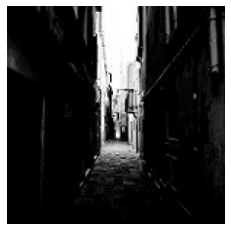

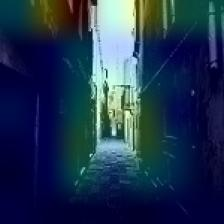

In [34]:
np.random.seed(None)

i = np.random.randint(0, 32)

print(i)

heatmap = make_gradcam_heatmap(input_image=sample_x[i], model=model)

print(heatmap.shape)

plt.imshow(sample_x[i])
plt.axis('off')
plt.show()

overlay_heatmap(sample_x[i] * 255.0, heatmap)

# **Feature Extraction**

In [45]:
feature_extractor = Model(model.inputs, model.get_layer('features').output)

In [47]:
def make_feature_data(data_generator, feature_extractor):
    
    x = []
    y = []
    
    for xi, yi in tqdm(data_generator):
        
        fi = feature_extractor.predict_on_batch(xi)
        
        x += fi.tolist()
        y += yi.tolist()
    
    x = np.array(x)
    y = np.array(y)
    
    return x, y

In [48]:
x_train, y_train = make_feature_data(train_data.as_numpy_iterator(), feature_extractor)

print(x_train.shape)
print(y_train.shape)

384it [01:06,  5.82it/s]


(12262, 4096)
(12262, 6)


In [49]:
x_val, y_val = make_feature_data(val_data.as_numpy_iterator(), feature_extractor)

print(x_val.shape)
print(y_val.shape)

43it [00:08,  5.34it/s]


(1365, 4096)
(1365, 6)


In [50]:
x_test, y_test = make_feature_data(test_generator(), feature_extractor)

print(x_test.shape)
print(y_test.shape)

3407it [00:49, 68.62it/s]


(3407, 4096)
(3407,)


In [51]:
np.savez('train_data.npz', x=x_train, y=y_train)
np.savez('val_data.npz', x=x_val, y=y_val)
np.savez('test_data.npz', x=x_test, id=y_test)

# **Pre-Ensemble**

In [38]:
def predict(data_generator, model):
    
    y = []
    
    for xi, _ in tqdm(data_generator):
        
        yi = model.predict_on_batch(xi)
        
        y += yi.tolist()
    
    y = np.array(y)
    
    return y

In [106]:
p_train = predict(train_data.as_numpy_iterator(), model)
p_val = predict(val_data.as_numpy_iterator(), model)
p_test = predict(test_generator(), model)

3407it [00:48, 70.38it/s]


In [107]:
np.savez('p_train_vgg16_v2.npz', y=p_train)
np.savez('p_val_vgg16_v2.npz', y=p_val)
np.savez('p_test_vgg16_v2.npz', y=p_test)

In [108]:
p_train = predict(train_data.as_numpy_iterator(), vgg16_v1)
p_val = predict(val_data.as_numpy_iterator(), vgg16_v1)
p_test = predict(test_generator(), vgg16_v1)

384it [00:45,  8.46it/s]
43it [00:05,  8.23it/s]
3407it [00:41, 82.19it/s]


In [109]:
np.savez('p_train_vgg16_v1.npz', y=p_train)
np.savez('p_val_vgg16_v1.npz', y=p_val)
np.savez('p_test_vgg16_v1.npz', y=p_test)

# **Ensemble**

In [113]:
def load(path):
    
    return dict(np.load(path))['y']

In [114]:
boosting_dir = '../input/cisc22placesandsceneboostingproba/'

In [159]:
# CNN
p_val_path = tf.io.gfile.glob('./p_val_*.npz')
p_test_path = tf.io.gfile.glob('./p_test_*.npz')

# Boosting
p_test_path += tf.io.gfile.glob(boosting_dir + 'y_proba*.npz')

p_val_path.sort()
p_test_path.sort()

print(p_val_path)
print(p_test_path)

['./p_val_vgg16_v1.npz', './p_val_vgg16_v2.npz']
['../input/cisc22placesandsceneboostingproba/y_proba_svc_0.npz', './p_test_vgg16_v1.npz', './p_test_vgg16_v2.npz']


In [160]:
val_pred = []

for path in p_val_path:
    
    val_pred.append(load(path))

val_pred = np.array(val_pred)

print(val_pred.shape)

(2, 1365, 6)


In [161]:
test_pred = []

for path in p_test_path:
    
    test_pred.append(load(path))

test_pred = np.array(test_pred)

print(test_pred.shape)

(3, 3407, 6)


In [178]:
v = 0.4 * val_pred[0] + 0.6 * val_pred[1]
v = v.argmax(axis=-1)

print((v == y_val.argmax(axis=-1)).mean())

0.9282051282051282


In [180]:
y = 0.3 * test_pred[0] + 0.3 * test_pred[1] + 0.4 * test_pred[2]
y = y.argmax(axis=-1)

In [181]:
submission = pd.read_csv(src_dir + 'sample_submission.csv')

submission.drop([0, 1], axis=0, inplace=True)

submission['image_name'] = y_test
submission['label'] = y

In [182]:
submission.to_csv('submission.csv', index=False, encoding='utf-8')

In [183]:
submission.head(5)


,image_name,label
0,22735.jpg,0
1,22706.jpg,0
2,13288.jpg,2
3,3863.jpg,1
4,22608.jpg,3
